1. **Kaggle team name**: 🐧F-BlueMoon-Acosta,Yoo
  1. Format: `🐧[BB Team#]-[Your fancy Kaggle group name]-[Students' names]`.
    1. Eg. `🐧A-Heros-Fleischer,Melnikov`, where `🐧` identifies JHU and `A` identifies the Canvas group code

Your private LB score must be reproducible with this Colab. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation). Don't exceed runtime quota.

<small><hr style="margin:0;background-color:silver"><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small>

In [ ]:
#Team member: Mauricio Acosta and Yungjun Yoo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<hr color=darkblue>

# **🏆💎Diamonds**

<details><summary><font color=darkblue>More info and Kaggle API instructions</font></summary>

[Kaggle competition URL](https://www.kaggle.com/c/jan-24-diamonds/rules). See competition rules, submission, grading, dataset, and performance metric. The **starter code** below produces a baseline model, which you should beat, while respecting the competition rules. Your code starts after the timer. This is your baseline model. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation) for reproducibility!

**Instructions for enabling Kaggle API in Colab**:
1. Accept competition rules before running [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials). [Loading Kaggle dataset example](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab)
1. In your Kaggle Account, [Create API Token](https://github.com/Kaggle/kaggle-api#api-credentials) and save the resulting **kaggle.json** file to the [root of your Google Drive](https://drive.google.com/drive/u/0/my-drive)
2. In Colab, open **Files** panel 🗀 (on the left) and click gray folder icon <font color=gray>🖿</font> to mount your Google drive

Your Kaggle/Google Drive credentials are secure; and Colab's kaggle.json only lasts a Colab session.

</details>


In [ ]:
#@title
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
#!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v jan-24-diamonds          # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

- competition is now set to: jan-24-diamonds
100% 3.30M/3.30M [00:00<00:00, 214MB/s]
Using competition: jan-24-diamonds
 teamId  teamName                                                  submissionDate       score       
-------  --------------------------------------------------------  -------------------  ----------  
8707191  Samuel Nathanson                                          2022-06-12 06:43:33  568.08182   
8076176  JC-AreForever-LeeMerran                                   2022-02-07 02:44:04  571.40711   
8102216  IB-Jötunheimr-Bakhtiyarov, Ivanushkina,Lukianov           2022-02-06 18:11:13  574.83942   
8059629  JG-TBD-Mendola Packard                                    2022-02-01 01:08:03  575.55421   
8056148  JD-TeamRocket-Corson-Hernandez                            2022-02-06 10:02:45  579.18701   
8058107  JA-ABAG-BarrettGivre                                      2022-02-03 02:53:11  579.52731   
8084977  JH-Code Breakers                                          2022-

In [ ]:
import os;
for i,j,k in os.walk('./'):
  print(i,j,k)
  break

./ ['.config', 'drive', 'sample_data'] ['jan-24-diamonds.zip', 'log', 'XY_diamonds.csv']


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 240 ms, sys: 73.2 ms, total: 313 ms
Wall time: 320 ms


In [ ]:
df = pd.read_csv('XY_diamonds.csv'); df

carat  depth  table     x     y     z cut color clarity   price
0        0.35   67.2   57.1  4.64  4.69  2.87   I     G     VS1     NaN
1        1.64   67.3   60.7  7.84  7.82  4.94   V     E     SI1     NaN
...       ...    ...    ...   ...   ...   ...  ..   ...     ...     ...
199998   0.48   68.7   53.0  4.47  4.45  2.72   I     G      IF  1474.0
199999   0.48   65.0   64.7  5.60  5.62  3.44   I     H     VS2   765.0

[200000 rows x 10 columns]

In [ ]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

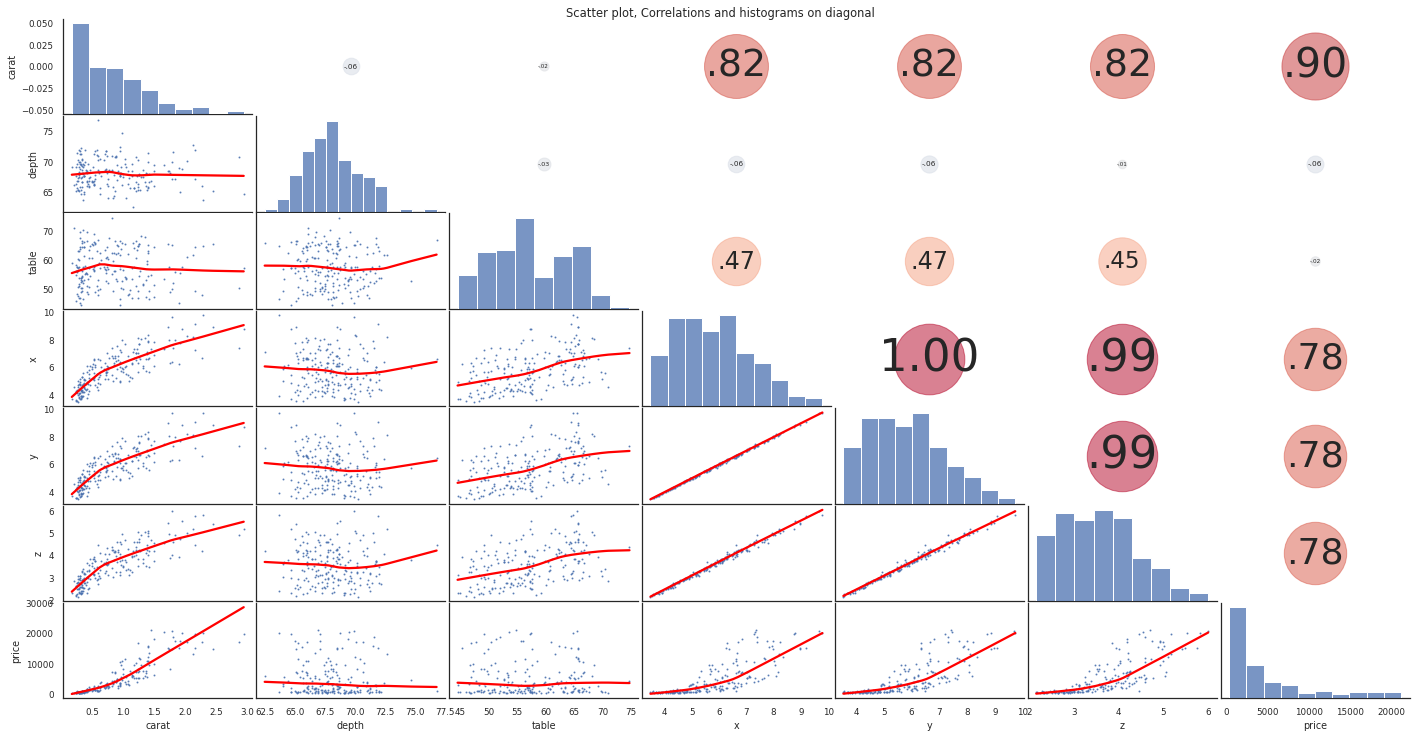

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(tXY.head(200))

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

<h1>Preprocessing
<p>In the previous steps we see that those instances in which the price information is missing were removed from the dataset, and the dataset we are thus working with has already been split  into our variable dataset, tX, and the respective prices, tY. Below we verify this</p>

In [ ]:
pd.options.display.max_rows=10
tX.head()

carat  depth  table     x     y     z cut color clarity
40000   0.36   69.5   61.3  4.58  4.52  2.84   P     H     VS1
40001   0.87   70.7   56.3  6.69  6.74  4.19   I     G     VS2
40002   0.54   67.2   65.8  6.15  6.18  3.75   V     D     SI2
40003   0.30   69.6   69.8  5.15  5.11  3.10   P     D     VS2
40004   0.60   68.6   49.4  4.88  4.91  2.96   P     E     SI1

Above we see that tX does indeed contain only the explanatory variables and not the target variable (price).
<p>Let's look at the target variable tY</p>

In [ ]:
tY.head()

40000     714.0
40001    7504.0
40002    1368.0
40003     923.0
40004    2873.0
Name: price, dtype: float64

We see here that the price data is indeed saved, with the corresponding ID. Therefore we will be working with the data contained in tX and tY.

<p>Let's look at some descriptive statistics

In [ ]:
tX.describe()

carat      depth      table          x          y          z
count  160000.00  160000.00  160000.00  160000.00  160000.00  160000.00
mean        0.80      67.86      57.45       5.73       5.74       3.54
std         0.49       2.53       7.02       1.31       1.33       0.81
min         0.16      45.60      36.40       0.00       0.00       0.00
25%         0.39      65.90      51.60       4.73       4.74       2.92
50%         0.68      67.80      57.40       5.57       5.57       3.44
75%         1.07      69.80      63.10       6.63       6.62       4.09
max         5.76      86.60      96.10      11.79      65.41       8.95

Something interesting to note is that all x,y,z have a minimum of 0, which is impossible. Also, we see that y has a maximum value of 65.41, indicating a possible data input error.Nonetheless given that we are going to perform a linear regression, we can assume that the intercept will contain the data for these zero'd values.

Let's seperate our training - test set so that we may safely explore our data without data snooping.

**Note that for the purposes of our competition, we have commented out unnecessary code

In [ ]:

#Define random state for all random number generators
randomState=123;


'''
from sklearn.model_selection import train_test_split

tX_train,tX_test=train_test_split(tX,test_size=.2,random_state=randomState)
'''

'\nfrom sklearn.model_selection import train_test_split\n\ntX_train,tX_test=train_test_split(tX,test_size=.2,random_state=randomState)\n'

Let's investigate other possible outliers for x,y,z

In [ ]:
'''
tX_train.loc[:,['x','y','z']].boxplot()
'''

"\ntX_train.loc[:,['x','y','z']].boxplot()\n"

Thus above we see candidate outliers where the y feature has values greater than 20. These are possible outliers. Let's view the relationship between y and price

In [ ]:
'''
fig,ax=plt.subplots(figsize=(10,6))
sns.scatterplot(x=tX_train['y'],y=tY[[x for x in tX_train.index]],hue=tX_train['x'],ax=ax);
'''

"\nfig,ax=plt.subplots(figsize=(10,6))\nsns.scatterplot(x=tX_train['y'],y=tY[[x for x in tX_train.index]],hue=tX_train['x'],ax=ax);\n"

Thus we see that indeed for values of y greater than 20 these diamonds deviate largely from the linear assumption. In addition, by including the X feature as hue, we also see that those data points with 0 for y also have 0 for x. These points also deviate largely from the rest of the data, indicating that it could be that these observations could have had missing data and were simply filled in with 0.

<p> With the data at hand, we now tackle the issue of having categorical variables, such as cut,color, and clarity.

In [ ]:
'''
print('Possible values for categorical variables')
for var in ['cut','color','clarity']:
  print(f'{var} : {tX_train[var].unique()}')
'''

"\nprint('Possible values for categorical variables')\nfor var in ['cut','color','clarity']:\n  print(f'{var} : {tX_train[var].unique()}')\n"

A bit of research into Diamonds and their characteristics yielded the following:
* The cut determines how much the diamond create sparkle and shines (https://www.bluenile.com/education/diamonds/cut)
    * This is an ordinal scale: Poor - Fair - Good - Very Good - Ideal

* The color of a diamond is actually graded on the absence of color (https://4cs.gia.edu/en-us/diamond-color/)
    * Color is also ordinal, which ranges from D - Z, where D is colorless, being of the highest grade.

* The clarity of a diamond refers to the amount of inclusions in the diamond (https://4cs.gia.edu/en-us/diamond-clarity/)
    * Diamond Clarity is also ordinal
        * Flawless (FL)
        * Internally Flawless (IF)
        * Very Very Slightly Included (VVS1 and VVS2)
        * Very Slightly Included (VS1 and VS2)
        * Slightly Included (SI1 and SI2)
        * Included (I1,I2,I3)

<p> Given these findings, we will initally transform these variables into sequential ordinal representations


#Feature Engineering
One obvious feature that we can estimate is the volume of the diamond by taking the product of x,y,z


In [ ]:
'''
pd.options.display.max_rows=10
tX_train['volume']=tX_train['x']*tX_train['y']*tX_train['z']
tX_train.describe()
y_greater_30=tX_train['y']>30
sns.scatterplot(x=tX_train['volume'],y=tY[[x for x in tX_train.index]],hue=y_greater_30)
'''

"\npd.options.display.max_rows=10\ntX_train['volume']=tX_train['x']*tX_train['y']*tX_train['z']\ntX_train.describe()\ny_greater_30=tX_train['y']>30\nsns.scatterplot(x=tX_train['volume'],y=tY[[x for x in tX_train.index]],hue=y_greater_30)\n"

From the graphic above we see that we do seem to have some outliers in our data that deviate strongly from the linear assumption. We can also see that these coincide with y values greater than about 30. Therefore this is more evidence that the previously identified candidate outliers should indeed be removed. Let's go ahead and remove these observations



<p>Let's encode our categorical data using an ordinal representation

In [ ]:
'''
tX_train_encoded=ordinal_encoder.fit_transform(tX_train[[x for x in ['cut','color','clarity']]])
tX_train[['cut','color','clarity']]=tX_train_encoded
'''

"\ntX_train_encoded=ordinal_encoder.fit_transform(tX_train[[x for x in ['cut','color','clarity']]])\ntX_train[['cut','color','clarity']]=tX_train_encoded\n"

Let's visualize the interplay between carat,clarity,cut, and color

In [ ]:
'''
fig,ax=plt.subplots(1,5,figsize=(20,5))
i=-1
for group,data in tX_train.groupby('cut'):
  i+=1
  sns.scatterplot(x=data['carat'],y=tY[[x for x in data.index]],ax=ax[i],hue=data['clarity'],alpha=.2)
  ax[i].set_title('Cut '+ str(group))
'''

"\nfig,ax=plt.subplots(1,5,figsize=(20,5))\ni=-1\nfor group,data in tX_train.groupby('cut'):\n  i+=1\n  sns.scatterplot(x=data['carat'],y=tY[[x for x in data.index]],ax=ax[i],hue=data['clarity'],alpha=.2)\n  ax[i].set_title('Cut '+ str(group))\n"

Above we see a few things. First of all we see that for all cuts, the relationship between carat and price seems to be nonlinear. In addition we also see that there is indeed some relationship between the clarity and the price. Let's view the relationship between the square of the feature and price

In [ ]:
'''
fig,ax=plt.subplots(1,5,figsize=(20,5))
sns.set()
for group,data in tX_train.groupby('cut'):
  sns.scatterplot(x=(data['carat'])**2,y=tY[[x for x in data.index]],ax=ax[int(group)],hue=data['clarity'],alpha=.2)
  ax[int(group)].set_title('Cut '+ str(group))
'''

"\nfig,ax=plt.subplots(1,5,figsize=(20,5))\nsns.set()\nfor group,data in tX_train.groupby('cut'):\n  sns.scatterplot(x=(data['carat'])**2,y=tY[[x for x in data.index]],ax=ax[int(group)],hue=data['clarity'],alpha=.2)\n  ax[int(group)].set_title('Cut '+ str(group))\n"

The graphic above clearly illustrates a linear relationship between price and carat**2 for most of the clarities, as well as showing the the slope of this relationship is steeper for higher clarity. The lower clarity does seem to have some sort of nonlinear trend. For now, let's include these attributes and their interactions in our model

Let's create our preprocessing pipeline for the linear regression, which takes as input the degree of the polynomial

<h1>Final Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import copy

from sklearn.preprocessing import OrdinalEncoder
import string

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
#one_hot_attrib=['cut']
clarity_cat=['I3','I2','I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF','FL']



cut_cat=['P','F','G','V','I']
#onehot_encoder=OneHotEncoder(categories=[cut_cat])
color_cat=list(string.ascii_uppercase)[3:][::-1]


ordinal_encoder=OrdinalEncoder(categories=[cut_cat,color_cat,clarity_cat])

cat_attribs=['cut','color','clarity']


cat_pipeline=ColumnTransformer([("cat",ordinal_encoder,cat_attribs)])
def final_pipeline(df,df_Y=None,deg=2,remove_outliers=False):
  df['greater1k']=[1 if x>1 else 0 for x in df['carat']]
  df['highClarity']=[1 if x in ['VVS2','VVS1','IF','FL'] else 0 for x in df['clarity']]
  #This function modifies the training dataset accordingly and returns both the
  #X dataframe and the corresponding Y dataframe if it is supplied
  if remove_outliers:
    df=copy.deepcopy(df.loc[(df['y']!=0) & (df['y']<=30)])
  df['volume']=df['x']*df['y']*df['z']
  #df_ohe=df[['cut']]
  #df_ohe_encoded=pd.DataFrame(onehot_encoder.fit_transform(df_ohe).toarray(),index=df_ohe.index)
  df=df.drop(['x','y','z'],axis=1)
  #df=pd.concat([df,df_ohe_encoded],axis=1)
  if type(df_Y)!=type(None):
    df_y=df_Y.loc[[x for x in df.index]]
  df[cat_attribs]=cat_pipeline.fit_transform(df)
  poly = PolynomialFeatures(degree=deg)
  df_poly = poly.fit_transform(df.select_dtypes(include=np.number))

  if type(df_Y)!=type(None):
    return df_poly,df_y
  else:
    return df_poly


<h1>K-fold cross validation</h1>
Commented out for runtime purposes

In [ ]:
'''
#Previously we had created tX_train,tX_test, but let's recreate it here for clarity.
#Furthermore, let's run a 5-fold cross validation
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from copy import deepcopy

lin_reg = LinearRegression()
#split data
tX_train,tX_test=train_test_split(tX,test_size=.2,random_state=randomState)

#kfold on only training

kf=KFold(n_splits=5,random_state=randomState,shuffle=True)
mae_test=[]
mae_training=[]
fig,ax=plt.subplots(figsize=(10,5))
count=-1
for train_index,test_index in kf.split(tX_train):
  count+=1
  df_train, df_test = tX_train.iloc[train_index].copy(),tX_train.iloc[test_index].copy()
  lin_reg = LinearRegression()
  tX0,tY0=final_pipeline(df_train,tY,deg=4,remove_outliers=True)
  lin_reg.fit(tX0,tY0)
  tY0_train_predicted=lin_reg.predict(tX0)
  mae_training.append(MAE(tY0,tY0_train_predicted))

  tX0_test,tY0_test=final_pipeline(df_test,tY,deg=4,remove_outliers=False)
  tY0_predicted=lin_reg.predict(tX0_test)
  tY0_predicted=[0 if y<0 else 1e6 if y>1e6 else y for y in tY0_predicted]
  #ax[count].plot(tY0_test-tY0_predicted,'.')
  mae_test.append(MAE(tY0_test,tY0_predicted))

ax.set_title('5-fold cross validation on final model: MAE of each fold')
ax.plot(mae_training,label='Training',marker='o',ls='-')
plt.plot(mae_test,marker='o',ls='-',label='Test')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.xticks(ticks=[0,1,2,3,4])
'''

"\n#Previously we had created tX_train,tX_test, but let's recreate it here for clarity.\n#Furthermore, let's run a 5-fold cross validation\nfrom sklearn.model_selection import cross_val_score,KFold\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import mean_absolute_error as MAE\nfrom copy import deepcopy\n\nlin_reg = LinearRegression()\n#split data\ntX_train,tX_test=train_test_split(tX,test_size=.2,random_state=randomState)\n\n#kfold on only training\n\nkf=KFold(n_splits=5,random_state=randomState,shuffle=True)\nmae_test=[]\nmae_training=[]\nfig,ax=plt.subplots(figsize=(10,5))\ncount=-1\nfor train_index,test_index in kf.split(tX_train):\n  count+=1\n  df_train, df_test = tX_train.iloc[train_index].copy(),tX_train.iloc[test_index].copy()\n  lin_reg = LinearRegression()\n  tX0,tY0=final_pipeline(df_train,tY,deg=4,remove_outliers=True)\n  lin_reg.fit(tX0,tY0)\n  tY0_train_predicted=lin_reg.predict(tX0)\n  mae_training.append(MAE(tY0,tY0_train_predicted))\n\n  tX0

Here we see that both the test and training have comparable MAE, indicating lack of overfit. Let's combine these and use them to predict on vX

<h1>Final Model and Submission

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


tX0,tY0=final_pipeline(tX,tY,deg=4,remove_outliers=True)

###########These Whole part will be uncommented if we want to apply ridge regression ###############
#model = Ridge()
#parameters = {'alpha':[0.1, 10]}
#m=GridSearchCV(model,parameters, cv=5)      #grid search with five fold cross validation
###########################################

###########These Whole part will be uncommented if we want use simple linear regression ############
m = LinearRegression();
####################################################################################################

#calculate the coefficients
m.fit(tX0,tY0)

#prediction on the test set
tY0_predicted=m.predict(tX0)
mae_test=MAE(tY0,tY0_predicted)
print(f"\n mae test = {mae_test}")

#prediction on the validation set
vX0=final_pipeline(vX,deg=4)
vY_predicted=m.predict(vX0);
pY = pd.DataFrame(vY_predicted, index=range(1,len(vY_predicted)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10,upper=1000000)  # ensures no negative prices

ToCSV(pY, 'MySubmission')

LinearRegression()


 mae test = 598.5278979060276


## **Task 1. Preprocessing Pipeline**

1. Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.
1. Why did you choose these elements? (Perhaps something in EDA or prior experience lead you to these)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?


**Student's answer:**

1. In preprocessing the data there were 4 main elements: outlier removal, categorical encoding (ordinal and onehot), feature engineering, and polynomial feature generation.
  * <b>Outlier removal</b>: One observation we made upon inspecting our data was the presence of few observations that deviated largely from the rest of the data. Namely we recognized observations whose "y" feature value was well beyond the typical values. Upon plotting our target value (price) against this feature, we noted that it did indeed also deviate largely from the general relationship observed. It could be that there was some data entry error. Thus we decided to remove these observations from our training data so that our model would not be influenced by these few observations. In addition, we also observed observations whose y value ( as well as x and z) was 0. Given that this is a physical dimension of the diamond, this does not make sense. It could be that these observations had the x,y,z measurments missing and were simply imputed to be 0. We verified this as well in our plot of "price" vs "y" with "x" as a hue and did indeed note that those values with zero y values did deviate from the general pattern as well. Thus we removed these observations from our training data.
  * <b>Categorical Encoding</b>: Our dataset contained 3 categorical variables: cut/color/clarity. We decided to perform an ordinal encoding of these variables given that they are ranked data. Research into each variable yielded all possible values, such as for color which ranges from D to Z. Thus all possible values were fit to the encoder so as to minimize the possibility of an unseen value in the testing data.
  * <b>Feature Engineering</b>: We decided to generate a volume feature, a high clarity binary feature, and  a "higher than 1 carat" binary feature. The volume feature was created in order to reduce the number of variables by combining x,y,z variables which were all highly correlated with each other. Given that the categorical variables are unlikely to all have equidistant representations, we would have liked to represent these as one hot encodings, more so for the clarity and cut. Nonetheless given the time/RAM constraint on running our code this was unfeasible given the combinatorial explosion of terms in our model for higher degree polynomial features. Thus we decided to use only ordinal encodings for the categorical variables and introduce the binary features for high clarity and high carat values. The greater-than-1-carat binary feature was decided given the relationship between price and carat. It is clear that this relationship has two regions where the slopes are very different. In addition, domain knowledge (https://beyond4cs.com/clarity/how-it-affects-pricing/) also revealed how the price of diamonds is relatively linear for the lower clarity grades, and then increases exponentially for higher clarities. Thus in order to capture this behavior without using a onehotencoding we simply categorized high/low clarity by introducing the binary feature "high_clarity".
  * <b> Polynomial feature generation</b>: Lastly we create all polynomial combinations of feature to degree 4. This was done in order to capture the interactions of the various features.

2. EDA revealed the presence of the outliers. The boxplot and descriptive statistics of y values revealed candidate outliers, and the scatterplot of price vs y as showed that these observations were indeed outliers.
  The encoding of the categorical variables was decided upon through research into the meanings of each variable as well as through cross-validation, as well as adherence to the timing limit of the competition. The cut, color, and clarity variables are indeed ordinal encodings in that there is an order to the various categories. Therefore for the color category, which contains 23 categories (D - Z), we used a ordinal encoding from Z (lowest) to D (highest). The clarity variable has about 11 categories, which was also decided to be ordinal, from Included (I3) to Flawless (FL). The last categorical variable, cut, has 5 categories, ranging from Poor (P) to Ideal (I). Thus had we wanted to use a onehotencoding scheme the combinatorial explosion would have been too much for the given time constraint. For example, even if we left the color category as ordinal and only applied the onehotencoding to the cut and color, we would have had 16 features for only cut and color. Thus this is why we decided to simply use an ordinal encoding of the three categorical variables.
  The feature engineering was driven largely by the limitation of the computational resources. Domain knowledge indicated that at least a 4th degree polynomial should be used given that the main drivers for the quality/price of a diamond is the 4 C's: cut, color, clarity, and carat. Thus it was desired for our model to somehow have the ability to integrate these interaction terms. Nonetheless as mentioned earlier, a onehotencoding was not feasible. Thus two binary features (high_clarity and high_carat) were created in order to capture some of this behavior. The higher-than-1-carat feature was deduced from the scatterplot for price vs carat since this visualization reveals that a piecewise-linear fit would yield a lower variance.

3. The main component in evaluating the effectiveness of the preprocessing was in performing a five-fold cross validation using the plausible representations of the data, as well as checking adherence to the 60 second time limit. In addition, various visualizations in EDA helped elucidate certain relationships as well as verifying the proper representation. For example, the scatterplot of price vs carat with clarity as a hue revelead how these 3 variables do have an interaction and should be present in our model.

4. Various approaches were taken in preprocessing the data. For example, although an ordinal encoding was decided to use for the categorical variables, nonequidistant steps were tried for the clarity feature. Namely an exponetial relationship between each category and it's encoding was explored.  Cross-validation didn't show a significant improvement compared to a simple ordinal representation. Thus in following occam's razor we decided to keep the encoding simple. As noted earlier a onehotencoding was tried for the cut and clarity variables. Adding these encodings to the 4th degree polynomial model did indeed show the best performance in terms of MAE, nonetheless it did not comply with the 60 second runtime constraint.  Therefore various combinations of sacrificing certain features in order to apply onehotencoding of the cut and clarity features was explored. Cross validation showed an increase in the average MAE whenever either table,depth,volume were removed from the features and as such we were unable to keep this model.  

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't

**Student's answer:**

1.
Linear regression is a simple and straightforward method that we can apply for the regression. Usually this is the first method we can consider once we meet the regression probelm.
First thing we can do before the decision is the EDA. Based on our EDA, most of the features looks like have linear relationship with the output. For some features, we applied square of the feature to make it closer to the linear. Therefore, we have decided to apply the linear regression to estimate the price.
Linear regression itself may have an issue with overfitting. Therefore, for better regularization, we can use Ridge or Lasso regression with hyper parameters to avoid the overfitting. For the ridge regression, alpha is a hyper parameter. However, tuning a hyper parameter takes time if we use grid-search. Also, it is tricky to find the acceptible range of the parameter because that is soley based on the guess.


2.
* <b> Scoring metric:</b>
First, we used the MAE (Mean Absolute Error) as our scoring metric because that is the requirement for this competition. We have calculated the MAE between the actual value and predcited value of the price from the traning set.

* <b> Running time:</b>
One important part for this competition is the running time. We are required to run every code within the time limit (which is 60 sec for this project). So we measured the execution time to check if the code can be run within the time limit.

* <b> Overfitting or Underfitting:</b>
Overfitting or underfitting would be a problem in terms of the generalization. To evaluate this, we performed the degree scan and check the trend of MAE. Our result and graph was shown above.

3.

* <b> cross-validation</b>

This is the most common things that Data Scientists or ML engineers evaluates how well the algorithm will be generalized. Here, we used five fold cross validation because this is the most widely used number. This helped to check if our choice of the parameter (such as polynomial degree) would lead to the overfitting or not.   

* <b> degree tuning</b>

For this project, selecting a proper polynomial degree was one of the key issue to lower down the MAE. We started from two and tested by gradually going up and down. While performing the degree tuning, we found out that degree 4 showed the best performance and we have checked this with cross-validation to see whether this choice can lead to overfitting or not.

* <b> application of Ridge or Lasso</b>

Ridge regression or Lasso regression is widely used to avoid the overfitting by applying the panelty for sudden change. We tried both. However, this did not help much on the performance (MAE). However, this took much greater time than the simple linear regression because it needs the grid search to find the optimal alpha value. Also, providing a proper range for parameter search was also tricky. Sometimes, Ridge or Lasso did not converge and this lead to more error in prediction. We have already removed the outlier after EDA and there were no sudden spike on our data set. Therefore, the effect of Ridge or Lasso was not substantial to the final performance. But it had a risk with the increasing the running time and failure of convergence. Therefore, we decided not to apply Ridge or Lasso on our model.

* <b> maximum usage of built-in library</b>

To minimize the run-time, we tried to utilize the built-in library function (such as sklearn, pandas or numpy) as much as possible. Built-in libraries are already optimized in run-time and validated by a lot of users. Therefore, maximize the usage of built-in library was a good strategy on reducing the run-time.



# **References:**
1. https://www.bluenile.com/education/diamonds/cut
2. https://4cs.gia.edu/en-us/diamond-color/
3. https://4cs.gia.edu/en-us/diamond-clarity/
4. https://towardsdatascience.com/clean-efficient-data-pipelines-with-pythons-sklearn-2472de04c0ea  (pipeline)
5. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
6. https://scikit-learn.org/stable/modules/model_evaluation.html
7. https://scikit-learn.org/stable/modules/cross_validation.html
8. Géron, A. (2019). Hands-on machine learning with scikit-learn, keras, and tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd edition). O'Reilly Media

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 17 sec
